***Méthodes numériques: Module 2***
***********************************
Space and Time: Modélisation de l'écoulement du trafic.
==
## Introduction #

Dans ce module nous allons résoudre une équation non-linéaire à deux variables en discrétisant à la fois dans le temps (en utilisant la forward-difference) et dans l'espace (en utilisant la backward-difference). Nous utiliserons également les nouveaux outils introduit dans ce module: sympy et lambdify, qui nous permettrons d'écrire des formules mathématiques dans nos codes et d'utiliser des fonctioncs de manière plus confortable. Nous importons donc comme dans le module 1 la librairie numpy et matplotlib pour pouvoir dessiner des graphiques mais également sympy et lambdify.

In [2]:
import numpy
import sympy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16
from sympy import init_printing
init_printing()
from sympy.utilities.lambdify import lambdify

## Principe #

L'équation que l'on se propose de résoudre est la suivante: $$\frac{\partial{\rho}}{\partial{t}}+\frac{\partial{F}}{\partial{\rho}}\frac{\partial{\rho}}{\partial{x}}=0$$ 

Cette équation modélise le flux du trafic de voitures sur l'autoroute. Il s'agit en fait de l'équation non-linéaire de convection appliquée à la densité de voiture, $\rho$. La fonction F représente le flux des voitures donné par $F=V \rho$ où V est la vitesse moyenne des voitures.

On modélise le fait que la vitesse varie en fonction de la densité de voiture en exprimant que la vitesse est maximale quand la densité de voiture est nulle et qu'elle est nulle quand la densité de voiture atteind une densité critique que l'on appelle $\rho_{max}$, ce qui se traduit par la formule suivante: 

$$V = V_{max}(1-\frac{\rho}{\rho_{max}})$$

Ainsi, on peut calculer que 
$$\frac{\partial{F}}{\partial{\rho}}=\frac{\partial{V \rho}}{\partial{\rho}} = V + \rho \frac{\partial{V}}{\partial{\rho}}$$

avec $$\frac{\partial{V}}{\partial{\rho}}=-\frac{V_{max}}{\rho_{max}}$$

On obtient finalement que $$\frac{\partial{F}}{\partial{\rho}}=V_{max} - 2\rho \frac{V_{max}}{\rho_{max}}$$
C'est-à-dire que l'équation que nous devons résoudre pour $\rho$ est $$\frac{\partial{\rho}}{\partial{t}}+(c_{1}\rho + c_{2})\frac{\partial{\rho}}{\partial{x}}=0$$ où $$c_{1}=-2\frac{V_{max}}{\rho_{max}}$$ et $$c_{2}=V_{max}$$

Il s'agit en fait d'une combinaison des deux exemples du Module 2. Maintenant que nous avons notre équation, nous pouvons la discrétiser. 
Les exposants représentent les indices de temps et les indices en dessous sont les indices pour l'espace. La discrétisation en avant pour le temps et en arrière pour l'espace nous donne l'équation suivante:
$$\frac{\rho_{i}^{n+1} - \rho_{i}^{n}}{\Delta t} + (c_{1}\rho_{i}^{n} + c_{2})(\frac{\rho_{i}^{n} - \rho_{i}^{n-1}}{\Delta x})=0$$

Dans cette équation, la seule inconnue à chaque itération est $\rho_{i}^{n+1}$. 

- On crée une fonction correspondant à F :

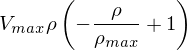

In [3]:
rho=sympy.symbols('rho')
V_max=sympy.symbols('V_max')
rho_max=sympy.symbols('rho_max')
F=rho*V_max*(1-rho/rho_max)

flamb=lambdify((rho,V_max,rho_max),F)

F


- Voyons l'allure de cette densité répartie sur la portion de route :

- À l'aide de notre fonction $\frac{\partial{F}}{\partial{\rho}}$ et de$$\frac{\rho_{i}^{n+1} - \rho_{i}^{n}}{\Delta t} + (c_{1}\rho_{i}^{n} + c_{2})(\frac{\rho_{i}^{n} - \rho_{i}^{n-1}}{\Delta x})=0$$ équivalent à : $$\rho_{i}^{n+1}=\rho_{i}^{n}-\frac{\Delta t}{\Delta x}(\rho_{i}^{n} - \rho_{i}^{n-1})\frac{\partial{F}}{\partial{\rho}}_{(\rho = \rho_{i}^{n})}$$

, nous trouvons la densité en fonction à un instant t défini par la valeur de nt choisie :

### Paramètres invariants du problème.

In [30]:
L=11
rhomax=250.
nx=51
dx=L/(nx-1)
dt=.001

### Fonction: Calcul de $\rho$ et $v$.
Fonction qui calcule la répartition de la densité de voitures et la vitesse du flot du trafic à un instant t=0.001*nt heures

In [31]:
def rho(initial,numberstep,bound,vmax):
    rho00=initial.copy()
    for n in range(1,numberstep): 
        rhocopy = rho00.copy() 
        rho00[1:] = rhocopy[1:]-dt/dx*(flamb(rhocopy[1:],vmax,rhomax)-flamb(rhocopy[0:-1],vmax,rhomax))
        rho00[0] = bound
    v=vmax*(1-rho00/rhomax)/3.6
    return (rho00,v)

## Simulation result: Part A.

In [32]:
x = numpy.linspace(0,L,nx)
rho0 = numpy.ones(nx)*10
rho0[10:20] = 50

- Voyons l'allure de cette densité répartie sur la portion de route :

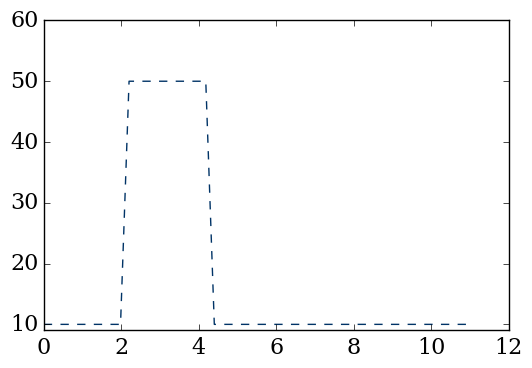

In [33]:
pyplot.plot(x, rho0, color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);

- Voici le graphique de la densité de voitures sur le segment de longueur 11 km au temps t=nt*0.001heure. nt est le second argument de la fonction rho, on peut le changer pour voir ce qu'il se passe.

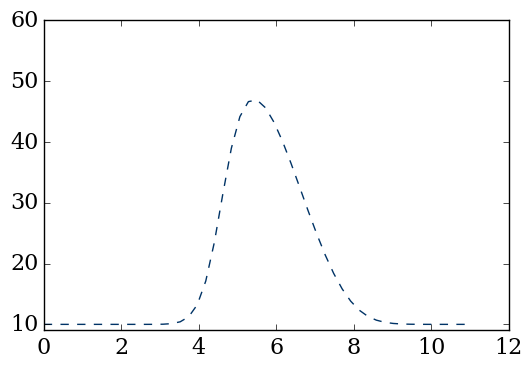

In [84]:
pyplot.plot(x,rho(rho0,42,10,80.0)[0], color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);

- On peut maintenant trouver la vitesse sur la portion de route à un certain instant grâce à la densité et à la formule : $V = V_{max}(1-\frac{\rho}{\rho_{max}})$

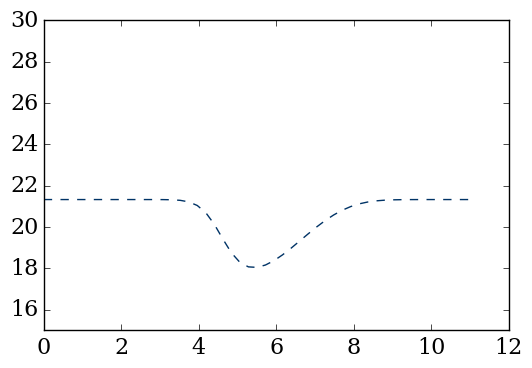

In [35]:
pyplot.plot(x,rho(rho0,42,10,80.0)[1], color='#003366', ls='--', lw=1)
pyplot.ylim(15.,30.);

## Simulation result: Part B.

In [37]:
x = numpy.linspace(0,L,nx)
rho1 = numpy.ones(nx)*20 
rho1[10:20] = 50

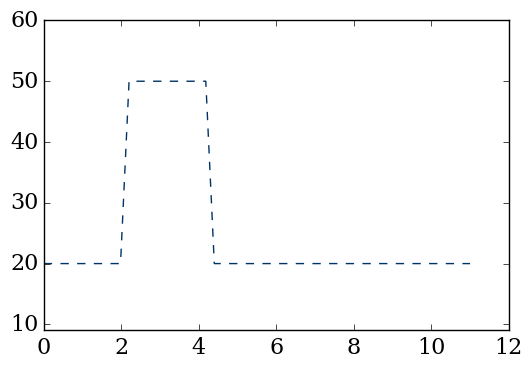

In [38]:
pyplot.plot(x, rho1, color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);

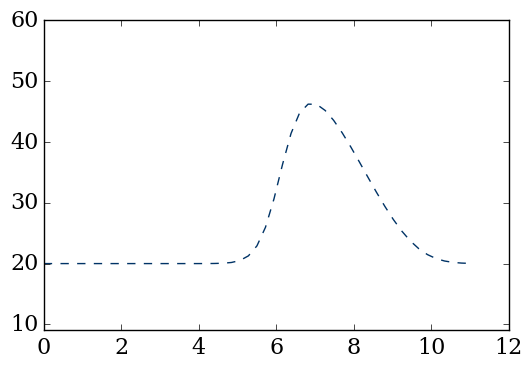

In [39]:
pyplot.plot(x,rho(rho1,42,20,136.0)[0], color='#003366', ls='--', lw=1)
pyplot.ylim(9.,60.);

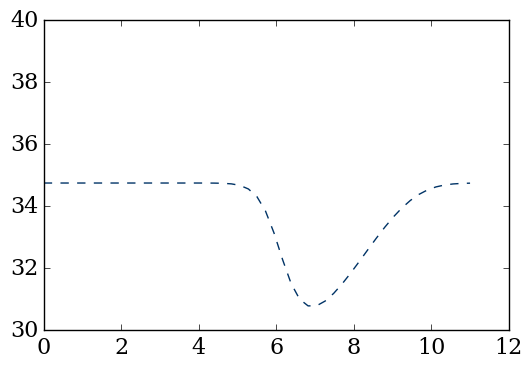

In [40]:
pyplot.plot(x,rho(rho1,42,20,136.0)[1], color='#003366', ls='--', lw=1)
pyplot.ylim(30,40);

Questions

In [41]:
def time(t):
    n=int(t/0.06)+1
    return n

In [43]:
def vmin(initial,t,bound,vmax):
    vmi=rho(initial,time(t),bound,vmax)[1]
    for i in range (0,nx-1):
        if vmi[i]>vmi[i+1]:
            minim=vmi[i+1]
    return(minim) 

In [49]:
vmin(rho0,6,10,80.0)

In [45]:
vmin(rho1,3,20,136.0)

In [50]:
def vmean(initial,t,bound,vmax):
    u=rho(initial,time(t),bound,vmax)[1]
    sumu=u[0]
    for i in range(1,nx):
        sumu=sumu+u[i]
    mean=sumu/(nx)
    return mean

In [51]:
vmean(rho1,3,20,136.0)

In [52]:
vmean(rho0,3,10,80.0)

## Bonus: vidéo

In [69]:
from matplotlib import animation
from IPython.display import HTML

In [70]:
nt=80
vmax=80.
u = numpy.ones(nx)*10
u[10:20] = 50
un=numpy.ones(nx)

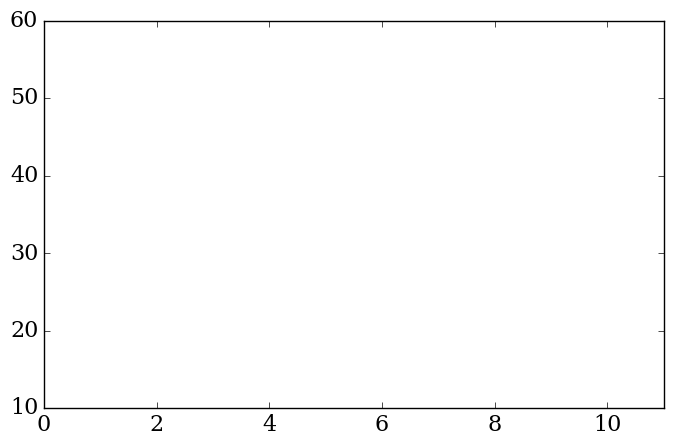

In [71]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes(xlim=(0,11), ylim=(10,60))
line = ax.plot([], [], color='#003366', ls='--', lw=3)[0]

In [72]:
def density(i):
    line.set_data(x,u)
    
    un = u.copy() 
    u[1:] = un[1:]-dt/dx*(flamb(un[1:],vmax,rhomax)-flamb(un[0:-1],vmax,rhomax))
    u[0] = bound

In [78]:
anim = animation.FFMpegWriter()

In [79]:
HTML(anim.to_html5_video())

AttributeError: 'FFMpegWriter' object has no attribute 'to_html5_video'